# PyTorch=1.4.0, NumPy=1.17.5, env=GWD

In [ ]:
#!pip install --no-deps 'timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps 'pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import utilities
sys.path.append('src/')
import utils as utils
from original_preprocessing import *

from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
import timm

In [2]:
sys.executable

'/Users/abigailmorgan/opt/anaconda3/envs/GWD/bin/python3.7'

In [3]:
torch.__version__

'1.4.0'

In [4]:
# define training and save paths and read in training csv and label key
data_dir = pathlib.Path('gwhd_2021/images/')
images = list(data_dir.glob('*.jpg'))

In [5]:
# Import data
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')
train = pd.read_csv('gwhd_2021/competition_train.csv')

# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)
# Merge dfs and preprocess

train_df = train.merge(metadata, on='domain')
test = pd.read_csv('gwhd_2021/competition_test.csv')
test_df = test.merge(metadata, on='domain')

In [6]:
train_df = utils.preprocess_df(train_df)
test_df = utils.preprocess_df(test_df)

In [7]:
train_df['bbox_area'] = train_df['bbox_width'] * train_df['bbox_height']
test_df['bbox_area'] = test_df['bbox_width'] * test_df['bbox_height']

In [8]:
max_area_threshold = 100000
min_area_threshold = 50

train_df = train_df[((train_df.bbox_area < max_area_threshold) & (train_df.bbox_area > min_area_threshold))]
test_df = test_df[((test_df.bbox_area < max_area_threshold) & (test_df.bbox_area > min_area_threshold))]

In [9]:
train_image_ids = train_df.image_name.unique()
test_image_ids = test_df.image_name.unique()

In [10]:
train_dataset = WheatDataset(
    image_ids=train_image_ids,
    labels_df= train_df,
    transforms=get_train_transforms(),
    test= False
)

validation_dataset = WheatDataset(
    image_ids=test_image_ids,
    labels_df=test_df,
    transforms= get_valid_transforms(),
    test=True
)

In [11]:
# Create dataloader
train_loader = DataLoader(train_dataset,
                         batch_size = TrainGlobalConfig.batch_size,
                         collate_fn = collate_fn,
                         shuffle=True)

validation_loader = DataLoader(validation_dataset,
                         batch_size = TrainGlobalConfig.batch_size,
                         collate_fn = collate_fn)

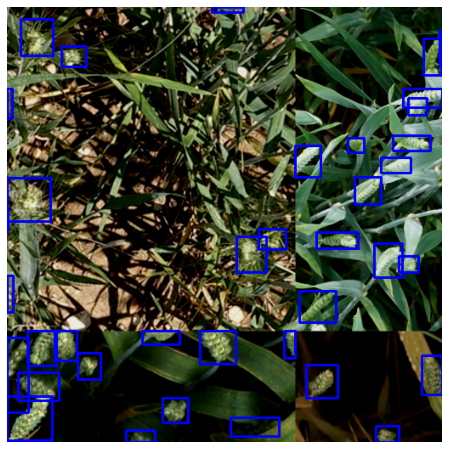

In [12]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    #cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 1)
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 0, 1), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

In [13]:
config = get_efficientdet_config('tf_efficientdet_d5')

config.image_size = [512,512]
config.norm_kwargs=dict(eps=.001, momentum=.01)

net = EfficientDet(config, pretrained_backbone=False)
checkpoint = torch.load('efficientdet_d5-ef44aea8.pth')
net.load_state_dict(checkpoint)


net.reset_head(num_classes=1)
net.class_net = HeadNet(config, num_outputs=config.num_classes)

# DetBenchTrain(net, config)

In [14]:
fitter = Fitter(model=net, device=None, config=TrainGlobalConfig)
fitter.fit(train_loader, validation_loader)

Fitter prepared. Device is None

2022-04-17T15:22:08.998415
LR: 0.0002


TypeError: forward() takes 2 positional arguments but 4 were given